In [2]:
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.robust import mad
import pandas as pd
from sklearn.linear_model import LassoLarsIC, Lasso
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# DATASETS

In [53]:
"""
Function to read electricity market data either locally or from an online database
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


def read_data(path, dataset='PJM', years_test=2, begin_test_date=None, end_test_date=None):
    """Function to read and import data from day-ahead electricity markets. 
    
    It receives a ``dataset`` name, and the ``path`` of the folder where datasets are saved. 
    It reads the file ``dataset.csv`` in the ``path`` directory and provides a split between training and
    testing dataset based on the test dates provided.

    It also names the columns of the training and testing dataset to match the requirements of the
    prediction models of the library. Namely, assuming that there are `N` exogenous inputs,
    the columns of the resulting training and testing dataframes are named
    ``['Price', 'Exogenous 1', 'Exogenous 2', ...., 'Exogenous N']``.

    If `dataset` is either ``"PJM"``, ``"NP"``, ``"BE"``, ``"FR"``, or ``"DE"``,
    the function checks whether ``dataset.csv`` exists in ``path``. If it doesn't exist,
    it downloads the data from an online database and saves it under the ``path`` directory. ``"PJM"``
    refes to the Pennsylvania-New Jersey-Maryland market, ``"NP"`` to the Nord Pool market,
    and ``"BE"``, ``"FR"``, and ``"DE"`` respectively to the EPEX-Belgium, EPEX-France, and EPEX-Germany 
    day-ahead markets.

    Note that the data available online for these five markets is limited to certain periods (see the 
    `database <https://sandbox.zenodo.org/record/632147>`_ for further details).  
    
    Parameters
    ----------
    path : str, optional
        Path where the datasets are stored or, if they do not exist yet, the path where the datasets 
        are to be stored
    nlayers : int, optional
        Number of hidden layers in the neural network
    dataset : str, optional
        Name of the dataset/market under study. If it is one one of the standard markets, 
        i.e. ``"PJM"``, ``"NP"``, ``"BE"``, ``"FR"``, or ``"DE"``, the dataset is automatically downloaded. If the name
        is different, a dataset with a csv format should be place in the ``path``.
    years_test : int, optional
        Number of years (a year is 364 days) in the test dataset. It is only used if 
        the arguments begin_test_date and end_test_date are not provided.
    begin_test_date : datetime/str, optional
        Optional parameter to select the test dataset. Used in combination with the argument
        ``end_test_date``. If either of them is not provided, the test dataset is built using the 
        ``years_test`` argument. ``begin_test_date`` should either be a string with the following 
        format ``"%d/%m/%Y %H:%M"``, or a datetime object.
    end_test_date : datetime/str, optional
        Optional parameter to select the test dataset. Used in combination with the argument
        ``begin_test_date``. If either of them is not provided, the test dataset is built using the 
        ``years_test`` argument. ``end_test_date`` should either be a string with the following 
        format ``"%d/%m/%Y %H:%M"``, or a datetime object.       
    Returns
    -------
    pandas.DataFrame, pandas.DataFrame
        Training dataset, testing dataset

    Example
    --------
    >>> from epftoolbox.data import read_data
    >>> df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date='01-01-2016', 
    ...                               end_test_date='01-02-2016')
    Test datasets: 2016-01-01 00:00:00 - 2016-02-01 23:00:00
    >>> df_train.tail()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2015-12-31 19:00:00  29.513832     100700.0      13015.0
    2015-12-31 20:00:00  28.440134      99832.0      12858.0
    2015-12-31 21:00:00  26.701700      97033.0      12626.0
    2015-12-31 22:00:00  23.262253      92022.0      12176.0
    2015-12-31 23:00:00  22.262431      86295.0      11434.0
    >>> df_test.head()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2016-01-01 00:00:00  20.341321      76840.0      10406.0
    2016-01-01 01:00:00  19.462741      74819.0      10075.0
    2016-01-01 02:00:00  17.172706      73182.0       9795.0
    2016-01-01 03:00:00  16.963876      72300.0       9632.0
    2016-01-01 04:00:00  17.403722      72535.0       9566.0
    >>> df_test.tail()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2016-02-01 19:00:00  28.056729      99400.0      12680.0
    2016-02-01 20:00:00  26.916456      97553.0      12495.0
    2016-02-01 21:00:00  24.041505      93983.0      12267.0
    2016-02-01 22:00:00  22.044896      88535.0      11747.0
    2016-02-01 23:00:00  20.593339      82900.0      10974.0

    """

    # Checking if provided directory exist and if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    # If dataset is one of the existing open-access ones,
    # they are imported if they exist locally or download from 
    # the repository if they do not
    if dataset in ['PJM', 'NP', 'FR', 'BE', 'DE']:
        file_path = os.path.join(path, dataset + '.csv')

        # The first time this function is called, the datasets
        # are downloaded and saved in a local folder
        # After the first called they are imported from the local
        # folder
        if os.path.exists(file_path):
            data = pd.read_csv(file_path, index_col=0)
        else:
            url_dir = 'https://sandbox.zenodo.org/api/files/fb5bae17-de91-4ce7-b348-0d62e52824b5/'
            data = pd.read_csv(url_dir + dataset + '.csv', index_col=0)
            data.to_csv(file_path)
    else:
        try:
            file_path = os.path.join(path, dataset + '.csv')
            data = pd.read_csv(file_path, index_col=0)
        except IOError as e:
            raise IOError("%s: %s" % (path, e.strerror))

    data.index = pd.to_datetime(data.index)

    columns = ['Price']
    n_exogeneous_inputs = len(data.columns) - 1

    for n_ex in range(1, n_exogeneous_inputs + 1):
        columns.append('Exogenous ' + str(n_ex))
        
    data.columns = columns

    # The training and test datasets can be defined by providing a number of years for testing
    # or by providing the init and end date of the test period
    if begin_test_date is None and end_test_date is None:
        number_datapoints = len(data.index)
        number_training_datapoints = number_datapoints - 24 * 364 * years_test

        # We consider that a year is 52 weeks (364 days) instead of the traditional 365
        df_train = data.loc[:data.index[0] + pd.Timedelta(hours=number_training_datapoints - 1), :]
        df_test = data.loc[data.index[0] + pd.Timedelta(hours=number_training_datapoints):, :]
    
    else:
        try:
            begin_test_date = pd.to_datetime(begin_test_date, dayfirst=True)
            end_test_date = pd.to_datetime(end_test_date, dayfirst=True)
        except ValueError:
            print("Provided values for dates are not valid")

        if begin_test_date.hour != 0:
            raise Exception("Starting date for test dataset should be midnight") 
        if end_test_date.hour != 23:
            if end_test_date.hour == 0:
                end_test_date = end_test_date + pd.Timedelta(hours=23)
            else:
                raise Exception("End date for test dataset should be at 0h or 23h") 

        print('Test datasets: {} - {}'.format(begin_test_date, end_test_date))
        df_train = data.loc[:begin_test_date - pd.Timedelta(hours=1), :]
        df_test = data.loc[begin_test_date:end_test_date, :]

    return df_train, df_test


# SCALER

In [54]:
"""
Classes and functions to implement data wrangling operations. At the moment, this is limited to
data scaling.
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


class MedianScaler(object):

    def __init__(self):
        self.fitted = False

    def fit(self, data):

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')
            return -1

        self.median = np.median(data, axis=0)
        self.mad = mad(data, axis=0)
        self.fitted = True
        
    def fit_transform(self, data):

        self.fit(data)
        return self.transform(data)
    
    def transform(self, data):

        if not self.fitted:
            print('Error: The scaler has not been yet fitted. Called fit or fit_transform')
            return -1

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')

        transformed_data = np.zeros(shape=data.shape)

        for i in range(data.shape[1]):

            transformed_data[:, i] = (data[:, i] - self.median[i]) / self.mad[i]

        return transformed_data

    def inverse_transform(self, data):

        if not self.fitted:
            print('Error: The scaler has not been yet fitted. Called fit or fit_transform')
            return -1

        if len(data.shape)!=2:
            raise IndexError('Error: Provide 2-D array. First dimension is datapoints and' + 
                  ' second features')

        transformed_data = np.zeros(shape=data.shape)

        for i in range(data.shape[1]):

            transformed_data[:, i] = data[:, i] * self.mad[i] + self.median[i] 

        return transformed_data


class InvariantScaler(MedianScaler):

    def __init__(self):
        super()

    def fit(self, data):

        super().fit(data)
        
    def fit_transform(self, data):

        self.fit(data)
        return self.transform(data)
    
    def transform(self, data):

        transformed_data = super().transform(data)
        transformed_data = np.arcsinh(transformed_data)

        return transformed_data

    def inverse_transform(self, data):

        transformed_data = np.sinh(data)
        transformed_data = super().inverse_transform(transformed_data)

        return transformed_data


class DataScaler(object):

    """Class to perform data scaling operations

    The scaling technique is defined by the ``normalize`` parameter which takes one of the 
    following values: 

    - ``'Norm'`` for normalizing the data to the interval [0, 1].

    - ``'Norm1'`` for normalizing the data to the interval [-1, 1]. 

    - ``'Std'`` for standarizing the data to follow a normal distribution. 

    - ``'Median'`` for normalizing the data based on the median as defined in as defined in `here <https://doi.org/10.1109/TPWRS.2017.2734563>`_.

    - ``'Invariant'`` for scaling the data based on the asinh transformation (a variance stabilizing transformations) as defined in `here <https://doi.org/10.1109/TPWRS.2017.2734563>`_. 
    
    This class follows the same syntax of the scalers defined in the 
    `sklearn.preprocessing <https://scikit-learn.org/stable/modules/preprocessing.html>`_ module of the 
    scikit-learn library

    Parameters
    ----------
    normalize : str
        Type of scaling to be performed. Possible values are ``'Norm'``, ``'Norm1'``, ``'Std'``, 
        ``'Median'``, or ``'Invariant'``

    Example
    --------
    >>> from epftoolbox.data import read_data
    >>> from epftoolbox.data import DataScaler
    >>> df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date='01-01-2016', end_test_date='01-02-2016')
    Test datasets: 2016-01-01 00:00:00 - 2016-02-01 23:00:00
    >>> df_train.tail()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2015-12-31 19:00:00  29.513832     100700.0      13015.0
    2015-12-31 20:00:00  28.440134      99832.0      12858.0
    2015-12-31 21:00:00  26.701700      97033.0      12626.0
    2015-12-31 22:00:00  23.262253      92022.0      12176.0
    2015-12-31 23:00:00  22.262431      86295.0      11434.0
    >>> df_test.head()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2016-01-01 00:00:00  20.341321      76840.0      10406.0
    2016-01-01 01:00:00  19.462741      74819.0      10075.0
    2016-01-01 02:00:00  17.172706      73182.0       9795.0
    2016-01-01 03:00:00  16.963876      72300.0       9632.0
    2016-01-01 04:00:00  17.403722      72535.0       9566.0
    >>> Xtrain = df_train.values
    >>> Xtest = df_train.values
    >>> scaler = DataScaler('Norm')
    >>> Xtrain_scaled = scaler.fit_transform(Xtrain)
    >>> Xtest_scaled = scaler.transform(Xtest)
    >>> Xtrain_inverse = scaler.inverse_transform(Xtrain_scaled)
    >>> Xtest_inverse = scaler.inverse_transform(Xtest_scaled)
    >>> Xtrain[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])
    >>> Xtrain_scaled[:3,:]
    array([[0.03833877, 0.2736787 , 0.28415155],
           [0.03608228, 0.24425597, 0.24633138],
           [0.03438982, 0.23016409, 0.2261206 ]])
    >>> Xtrain_inverse[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])
    >>> Xtest[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])
    >>> Xtest_scaled[:3,:]
    array([[0.03833877, 0.2736787 , 0.28415155],
           [0.03608228, 0.24425597, 0.24633138],
           [0.03438982, 0.23016409, 0.2261206 ]])
    >>> Xtest_inverse[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])
    """
    
    def __init__(self, normalize):

        if normalize == 'Norm':
            self.scaler = MinMaxScaler(feature_range=(0, 1))
        elif normalize == 'Norm1':
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
        elif normalize == 'Std':
            self.scaler = StandardScaler()
        elif normalize == 'Median':
            self.scaler = MedianScaler()
        elif normalize == 'Invariant':
            self.scaler = InvariantScaler()        

    def fit_transform(self, dataset):
        """Method that estimates an scaler object using the data in ``dataset`` and scales the data in  ``dataset``
        
        Parameters
        ----------
        dataset : numpy.array
            Dataset used to estimate the scaler
        
        Returns
        -------
        numpy.array
            Scaled data
        """

        return self.scaler.fit_transform(dataset)

    def transform(self, dataset):
        """Method that scales the data in ``dataset``
        
        It must be called after calling the :class:`fit_transform` method for estimating the scaler
        Parameters
        ----------
        dataset : numpy.array
            Dataset to be scaled
        
        Returns
        -------
        numpy.array
            Scaled data
        """

        return self.scaler.transform(dataset)

    def inverse_transform(self, dataset):
        """Method that inverse-scale the data in ``dataset``
        
        It must be called after calling the :class:`fit_transform` method for estimating the scaler

        Parameters
        ----------
        dataset : numpy.array
            Dataset to be scaled
        
        Returns
        -------
        numpy.array
            Inverse-scaled data
        """

        return self.scaler.inverse_transform(dataset)

def scaling(datasets, normalize):
    """Function that scales data and returns the scaled data and the :class:`DataScaler` used for scaling.

    It rescales all the datasets contained in the list ``datasets`` using the first dataset as reference. 
    For example, if ``datasets=[X_1, X_2, X_3]``, the function estimates a :class:`DataScaler` object using the array ``X_1``, 
    and transform ``X_1``, ``X_2``, and ``X_3`` using the :class:`DataScaler` object.

    Each dataset must be a numpy.array and it should have the same column-dimensions. For example, if
    ``datasets=[X_1, X_2, X_3]``, ``X_1`` must be a numpy.array of size ``[n_1, m]``,
    ``X_2`` of size ``[n_2, m]``, and ``X_3`` of size ``[n_3, m]``, where ``n_1``, ``n_2``, ``n_3`` can be
    different.

    The scaling technique is defined by the ``normalize`` parameter which takes one of the 
    following values: 

    - ``'Norm'`` for normalizing the data to the interval [0, 1].

    - ``'Norm1'`` for normalizing the data to the interval [-1, 1]. 

    - ``'Std'`` for standarizing the data to follow a normal distribution. 

    - ``'Median'`` for normalizing the data based on the median as defined in as defined in `here <https://doi.org/10.1109/TPWRS.2017.2734563>`_.

    - ``'Invariant'`` for scaling the data based on the asinh transformation (a variance stabilizing transformations) as defined in `here <https://doi.org/10.1109/TPWRS.2017.2734563>`_. 


    The function returns the scaled data together with a :class:`DataScaler` object representing the scaling. 
    This object can be used to scale other dataset using the same rules or to inverse-transform the data.
    
    Parameters
    ----------
    datasets : list
        List of numpy.array objects to be scaled.
    normalize : str
        Type of scaling to be performed. Possible values are ``'Norm'``, ``'Norm1'``, ``'Std'``, 
        ``'Median'``, or ``'Invariant'``
    
    Returns
    -------
    List, :class:`DataScaler`
        List of scaled datasets and the :class:`DataScaler` object used for scaling. Each dataset in the 
        list is a numpy.array.
    
    Example
    --------
    >>> from epftoolbox.data import read_data
    >>> from epftoolbox.data import scaling
    >>> df_train, df_test = read_data(path='.', dataset='PJM', begin_test_date='01-01-2016', end_test_date='01-02-2016')
    Test datasets: 2016-01-01 00:00:00 - 2016-02-01 23:00:00
    >>> df_train.tail()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2015-12-31 19:00:00  29.513832     100700.0      13015.0
    2015-12-31 20:00:00  28.440134      99832.0      12858.0
    2015-12-31 21:00:00  26.701700      97033.0      12626.0
    2015-12-31 22:00:00  23.262253      92022.0      12176.0
    2015-12-31 23:00:00  22.262431      86295.0      11434.0
    >>> df_test.head()
                             Price  Exogenous 1  Exogenous 2
    Date                                                    
    2016-01-01 00:00:00  20.341321      76840.0      10406.0
    2016-01-01 01:00:00  19.462741      74819.0      10075.0
    2016-01-01 02:00:00  17.172706      73182.0       9795.0
    2016-01-01 03:00:00  16.963876      72300.0       9632.0
    2016-01-01 04:00:00  17.403722      72535.0       9566.0
    >>> Xtrain = df_train.values
    >>> Xtest = df_train.values
    >>> [Xtrain_scaled, Xtest_scaled], scaler = scaling([Xtrain,Xtest],'Norm')
    >>> Xtrain[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])
    >>> Xtrain_scaled[:3,:]
    array([[0.03833877, 0.2736787 , 0.28415155],
           [0.03608228, 0.24425597, 0.24633138],
           [0.03438982, 0.23016409, 0.2261206 ]])
    >>> Xtest[:3,:]
    array([[2.5464211e+01, 8.5049000e+04, 1.1509000e+04],
           [2.3554578e+01, 8.2128000e+04, 1.0942000e+04],
           [2.2122277e+01, 8.0729000e+04, 1.0639000e+04]])           
    >>> Xtest_scaled[:3,:]
    array([[0.03833877, 0.2736787 , 0.28415155],
           [0.03608228, 0.24425597, 0.24633138],
           [0.03438982, 0.23016409, 0.2261206 ]])
    >>> type(scaler)
    <class 'epftoolbox.data._wrangling.DataScaler'>

    """

    scaler = DataScaler(normalize)

    for i, dataset in enumerate(datasets):
        if i == 0:
            dataset = scaler.fit_transform(dataset)
        else:
            dataset = scaler.transform(dataset)

        datasets[i] = dataset

    return datasets, scaler

# METRIC HELPER

In [55]:
"""
Ancillary functions to compute accuracy metrics and statistical tests in the context of electricity price
forecasting
"""

def _process_inputs_for_metrics(p_real, p_pred):
    """Function that checks that the two standard inputs of the metric functions satisfy some requirements
    
    
    Parameters
    ----------
    p_real : numpy.ndarray, pandas.DataFrame, pandas.Series
        Array/dataframe containing the real prices
    p_pred : numpy.ndarray, pandas.DataFrame, pandas.Series
        Array/dataframe containing the predicted prices
    
    Returns
    -------
    np.ndarray, np.ndarray
        The p_real and p_pred as numpy.ndarray objects after checking that they satisfy requirements 
    
    """
    
    # Checking that both arrays are of the same type
    if type(p_real) != type(p_pred):
        raise TypeError('p_real and p_pred must be of the same type. p_real is of type {}'.format(type(p_real)) +
            ' and p_pred of type {}'.format(type(p_pred)))

    # Checking that arrays are of the allowed types
    if type(p_real) != pd.DataFrame and \
       type(p_real) != pd.Series and \
       type(p_real) != np.ndarray:
        raise TypeError('p_real and p_pred must be either a pandas.DataFrame, a pandas.Serie, or ' +
        ' a numpy.aray. They are of type {}'.format(type(p_real)))

    # Transforming dataset if it is a pandas.Series to pandas.DataFrame
    if type(p_real) == pd.Series:
        p_real = p_real.to_frame()
        p_pred = p_pred.to_frame()
    
    # Checking that both datasets share the same indices
    if type(p_real) == pd.DataFrame:
        if not (p_real.index == p_pred.index).all():
            raise ValueError('p_real and p_pred must have the same indices')

        # Extracting their values as numpy.ndarrays
        p_real = p_real.values.squeeze()
        p_pred = p_pred.values.squeeze()

    return p_real, p_pred

def naive_forecast(p_real, m=None, n_prices_day=24):
    """Function to buil the naive forecast for electricity price forecasting
    
    The function is used to compute the accuracy metrics MASE and RMAE
        
    Parameters
    ----------
    p_real : pandas.DataFrame
        Dataframe containing the real prices. It must be of shape :math:`(n_\\mathrm{prices}, 1)`,
    m : int, optional
        Index that specifies the seasonality in the naive forecast. It can
        be ``'D'`` for daily seasonality, ``'W'`` for weekly seasonality, or ``None``
        for the standard naive forecast in electricity price forecasting, 
        i.e. daily seasonality for Tuesday to Friday and weekly seasonality 
        for Saturday to Monday.
    n_prices_day : int, optional
        Number of prices in a day. Usually this value is 24 for most day-ahead markets
    
    Returns
    -------
    pandas.DataFrame
        Dataframe containing the predictions of the naive forecast.
    """

    # Init the naive forecast
    if m is None or m == 'W':
        index = p_real.index[n_prices_day * 7:]
        Y_pred = pd.DataFrame(index=index, columns=p_real.columns)
    else:
        index = p_real.index[n_prices_day:]
        Y_pred = pd.DataFrame(index=index, columns=p_real.columns)

    # If m is none the standard naive for EPF is built
    if m is None:

        # Monday we have a naive forecast using daily seasonality
        indices_mon = Y_pred.index[Y_pred.index.dayofweek == 0]
        Y_pred.loc[indices_mon, :] = p_real.loc[indices_mon - pd.Timedelta(days=7), :].values

        # Tuesdays we have a naive forecast using daily seasonality
        indices_tue = Y_pred.index[Y_pred.index.dayofweek == 1]
        Y_pred.loc[indices_tue, :] = p_real.loc[indices_tue - pd.Timedelta(days=1), :].values

        # Wednesday we have a naive forecast using daily seasonality
        indices_wed = Y_pred.index[Y_pred.index.dayofweek == 2]
        Y_pred.loc[indices_wed, :] = p_real.loc[indices_wed - pd.Timedelta(days=1), :].values

        # Thursday we have a naive forecast using daily seasonality
        indices_thu = Y_pred.index[Y_pred.index.dayofweek == 3]
        Y_pred.loc[indices_thu, :] = p_real.loc[indices_thu - pd.Timedelta(days=1), :].values

        # Friday we have a naive forecast using daily seasonality
        indices_fri = Y_pred.index[Y_pred.index.dayofweek == 4]
        Y_pred.loc[indices_fri, :] = p_real.loc[indices_fri - pd.Timedelta(days=1), :].values

        # Saturday we have a naive forecast using weekly seasonality
        indices_sat = Y_pred.index[Y_pred.index.dayofweek == 5]
        Y_pred.loc[indices_sat, :] = p_real.loc[indices_sat - pd.Timedelta(days=7), :].values

        # Sunday we have a naive forecast using weekly seasonality
        indices_sun = Y_pred.index[Y_pred.index.dayofweek == 6]
        Y_pred.loc[indices_sun, :] = p_real.loc[indices_sun - pd.Timedelta(days=7), :].values

    # If m is either 24 or 168 naive forecast simply built using a seasonal naive forecast
    elif m == 'D':
        Y_pred.loc[:, :] = p_real.loc[Y_pred.index - pd.Timedelta(days=1)].values
    elif m == 'W':
        Y_pred.loc[:, :] = p_real.loc[Y_pred.index - pd.Timedelta(days=7)].values

    return Y_pred

def _transform_input_prices_for_naive_forecast(p_real, m, freq):
    """Function that ensures that the input of the naive forecast has the right format
    
    Parameters
    ----------
    p_real : numpy.ndarray, pandas.DataFrame, pandas.Series
        Array/dataframe containing the real prices
    m : int, optional
        Index that specifies the seasonality in the naive forecast. It can
        be ``'D'`` for daily seasonality, ``'W'`` for weekly seasonality, or None
        for the standard naive forecast in electricity price forecasting, 
        i.e. daily seasonality for Tuesday to Friday and weekly seasonality 
        for Saturday to Monday.
    freq : str
        Frequency of the data if ``p_real`` are numpy.ndarray objects.
        It must take one of the following four values ``'1H'`` for 1 hour, ``'30T'`` for 30 minutes, 
        ``'15T'`` for 15 minutes, or ``'5T'`` for 5 minutes,  (these are the four standard values in 
        day-ahead electricity markets). If the shape of ``p_real`` is (ndays, n_prices_day), 
        freq should be the frequency of the columns not the daily frequency of the rows.    
    Returns
    -------
    pandas.DataFrame
        ``p_real`` as a pandas.DataFrame that can be used for the naive forecast 
    """

    # Ensure that m value is correct
    if m not in ['D', 'W', None]: 
        raise ValueError('m argument has to be D, W, or None. Current values is {}'.format(m))    

    # Check that input data is not numpy.ndarray and naive forecast is standard
    if m is None and type(p_real) != pd.DataFrame and type(p_real) != pd.Series:
        raise TypeError('To use the standard naive forecast, i.e. m=None, the input' +
            ' data has to be pandas.DataFrame object.')

    # Defining number of prices per day depending on frequency
    n_prices_day = {'1H': 24, '30T': 48, '15T': 96, '5T': 288, '1T': 1440}[freq]

    # If numpy arrays are used, ensure that there is integer number of days in the dataset
    if type(p_real) == np.ndarray and p_real.size % n_prices_day != 0:
        raise ValueError('If numpy arrays are used, the size of p_real, i.e. the number of prices it '
            + 'contains, should be a multiple number of {}, i.e. of the number of '.format(n_prices_day)
            + ' prices per day. Current values is {}'.format(p_real.size))    
    
    # If pandas.Series are used, convert to DataFrame
    if type(p_real) == pd.Series:
        p_real = p_real.to_frame()

    # If input data is numpy.ndarray, transform to pandas.DataFrame
    if type(p_real) == np.ndarray:
        # Transforming p_real to correct shape, i.e. (nprices, 1)
        p_real = p_real.reshape(-1, 1)
        # Building time indices for DataFrame
        indices = pd.date_range(start='2013-01-01', periods=p_real.shape[0], freq=freq)        
        # Building DataFrame
        p_real = pd.DataFrame(p_real, index=indices)
    
    # If input data is pandas-based, make sure it is in correct shape
    elif type(p_real) == pd.DataFrame:
        # Making sure that index is of datetime format
        p_real.index = pd.to_datetime(p_real.index)

        # Raising error if frequency cannot be inferred
        if p_real.index.inferred_freq is None:
            raise ValueError('The frequency/time periodicity of the data could not be inferred. '
                + 'Ensure that the indices of the dataframe have a correct format and are equally separated.')

        # If shape (ndays, n_prices_day), ensure that frequency of index is daily        
        if p_real.shape[1] > 1 and p_real.index.inferred_freq != 'D':
            raise ValueError('If pandas dataframes are used with arrays with shape ' 
                + '(ndays, n_prices_day), the frequency of the time indices should be 1 day. '
                + 'At the moment it is {}.'.format(p_real.index.inferred_freq))

        # Reshaping dataframe if shape (ndays, n_prices_day)
        if p_real.shape[1] > 1:
            # Inferring frequency within a day
            frequency_seconds = 24 * 60 * 60 / p_real.shape[1]
            # Infering last date in the dataset based on the frequency of points within a day
            last_date = p_real.index[-1] + (p_real.shape[1] - 1) * pd.Timedelta(seconds=frequency_seconds)
            # Inferring indices
            indices = pd.date_range(start=p_real.index[0], end=last_date, periods=p_real.size)
            # Reshaping prices
            p_real = pd.DataFrame(data=p_real.values.reshape(-1, 1), columns=['Prices'], index=indices)

    # Raising error if p_real not of specified type
    else:
        raise TypeError('Input should be of type numpy.ndarray, pandas.DataFrame, or pandas.Series' +
            ' but it is of type {}'.format(type(p_real)))

    return p_real



# METRICS

In [56]:
"""
Function that implements the mean absolute error (MAE) metric.
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


def MAE(p_real, p_pred):
    """Function that computes the mean absolute error (MAE) between two forecasts:

    .. math:: 
        \\mathrm{MAE} = \\frac{1}{N}\\sum_{i=1}^N \\bigl|p_\\mathrm{real}[i]-p_\\mathrm{pred}[i]\\bigr|    

    ``p_real`` and ``p_pred`` can either be of shape 
    :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})`,
    :math:`(n_\\mathrm{prices}, 1)`, or :math:`(n_\\mathrm{prices}, )` where
    :math:`n_\\mathrm{prices} = n_\\mathrm{days} \\cdot n_\\mathrm{prices/day}`.

    Parameters
    ----------
    p_real : numpy.ndarray, pandas.DataFrame, pandas.Series
        Array/dataframe containing the real prices.
    p_pred : numpy.ndarray, pandas.DataFrame, pandas.Series
        Array/dataframe containing the predicted prices.
    
    Returns
    -------
    float
        The mean absolute error (MAE).

    Example
    --------

    >>> from epftoolbox.evaluation import MAE
    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)

    >>> 
    >>> # Transforming indices to datetime format
    >>> forecast.index = pd.to_datetime(forecast.index)
    >>> 
    >>> # Reading data from the NP market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecast.index[0], 
    ...                        end_test_date=forecast.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> # Extracting forecast of DNN ensemble and display
    >>> fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
    >>> 
    >>> # Extracting real price and display
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Building the same datasets with shape (ndays, n_prices/day) 
    >>> # instead of shape (nprices, 1) and display
    >>> fc_DNN_ensemble_2D = pd.DataFrame(fc_DNN_ensemble.values.reshape(-1, 24), 
    ...                                   index=fc_DNN_ensemble.index[::24], 
    ...                                   columns=['h' + str(hour) for hour in range(24)])
    >>> real_price_2D = pd.DataFrame(real_price.values.reshape(-1, 24), 
    ...                              index=real_price.index[::24], 
    ...                              columns=['h' + str(hour) for hour in range(24)])
    >>> fc_DNN_ensemble_2D.head()
                       h0         h1         h2  ...        h21        h22        h23
    2016-12-27  24.349676  23.127774  22.208617  ...  27.686771  27.045763  25.724071
    2016-12-28  25.453866  24.707317  24.452384  ...  29.424558  28.627130  27.321902
    2016-12-29  28.209516  27.715400  27.182692  ...  28.473288  27.926241  27.153401
    2016-12-30  28.002935  27.467572  27.028558  ...  29.086532  28.518688  27.738548
    2016-12-31  25.732282  24.668331  23.951569  ...  26.965008  26.450995  25.637346 
     
    According to the paper, the MAE of the DNN ensemble for the NP market is 1.667
    Let's test the metric for different conditions
     
    >>> # Evaluating MAE when real price and forecasts are both dataframes
    >>> MAE(p_pred=fc_DNN_ensemble, p_real=real_price)
    1.6670355192007669
    >>> 
    >>> # Evaluating MAE when real price and forecasts are both numpy arrays
    >>> MAE(p_pred=fc_DNN_ensemble.values, p_real=real_price.values)
    1.6670355192007669
    >>> 
    >>> # Evaluating MAE when input values are of shape (ndays, n_prices/day) 
    >>> # instead of shape (nprices, 1)
    >>> # Dataframes
    >>> MAE(p_pred=fc_DNN_ensemble_2D, p_real=real_price_2D)
    1.6670355192007669
    >>> # Numpy arrays
    >>> MAE(p_pred=fc_DNN_ensemble_2D.values, p_real=real_price_2D.values)
    1.6670355192007669
    >>> 
    >>> # Evaluating MAE when input values are of shape (nprices,) 
    >>> # instead of shape (nprices, 1)
    >>> # Pandas Series
    >>> MAE(p_pred=fc_DNN_ensemble.loc[:, 'DNN Ensemble'], 
    ...     p_real=real_price.loc[:, 'Price'])
    1.6670355192007669
    >>> # Numpy arrays
    >>> MAE(p_pred=fc_DNN_ensemble.values.squeeze(), 
    ...     p_real=real_price.values.squeeze())
    1.6670355192007669
    """

    # Checking if inputs are compatible
    p_real, p_pred = _process_inputs_for_metrics(p_real, p_pred)

    return np.mean(np.abs(p_real - p_pred))


In [57]:
"""
Function that implements the mean absolute percentage error (MAPE) metric.
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


def MAPE(p_real, p_pred, noNaN=False):

    """Function that computes the mean absolute percentage error (MAPE) between two forecasts:

    .. math:: 
        \\mathrm{MAPE} = \\frac{1}{N}\\sum_{i=1}^N \\frac{\\bigl|p_\\mathrm{real}[i]−p_\\mathrm{pred}[i]\\bigr|}{
        \\bigl|Y_\\mathrm{real}[i]\\bigr|}    

    ``p_real`` and ``p_pred`` can either be of shape 
    :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})`,
    :math:`(n_\\mathrm{prices}, 1)`, or :math:`(n_\\mathrm{prices}, )` where
    :math:`n_\\mathrm{prices} = n_\\mathrm{days} \\cdot n_\\mathrm{prices/day}`.
    
    Parameters
    ----------
    p_real : numpy.ndarray, pandas.DataFrame
        Array/dataframe containing the real prices.
    p_pred : numpy.ndarray, pandas.DataFrame
        Array/dataframe containing the predicted prices.
    noNaN : bool, optional
        Bool to remove the NaN values resulting of dividing by 0 in the MAPE. It has to be used
        if any value in p_real is 0.
    Returns
    -------
    float
        The mean absolute percentage error (MAPE).

    Example
    ----------

    >>> from epftoolbox.evaluation import MAPE
    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
    >>> 
    >>> # Transforming indices to datetime format
    >>> forecast.index = pd.to_datetime(forecast.index)
    >>> 
    >>> # Reading data from the NP market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecast.index[0], 
    ...                        end_test_date=forecast.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> # Extracting forecast of DNN ensemble and display
    >>> fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
    >>> 
    >>> # Extracting real price and display
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Building the same datasets with shape (ndays, n_prices/day) instead 
    >>> # of shape (nprices, 1) and display
    >>> fc_DNN_ensemble_2D = pd.DataFrame(fc_DNN_ensemble.values.reshape(-1, 24), 
    ...                                   index=fc_DNN_ensemble.index[::24], 
    ...                                   columns=['h' + str(hour) for hour in range(24)])
    >>> real_price_2D = pd.DataFrame(real_price.values.reshape(-1, 24), 
    ...                              index=real_price.index[::24], 
    ...                              columns=['h' + str(hour) for hour in range(24)])
    >>> fc_DNN_ensemble_2D.head()
                       h0         h1         h2  ...        h21        h22        h23
    2016-12-27  24.349676  23.127774  22.208617  ...  27.686771  27.045763  25.724071
    2016-12-28  25.453866  24.707317  24.452384  ...  29.424558  28.627130  27.321902
    2016-12-29  28.209516  27.715400  27.182692  ...  28.473288  27.926241  27.153401
    2016-12-30  28.002935  27.467572  27.028558  ...  29.086532  28.518688  27.738548
    2016-12-31  25.732282  24.668331  23.951569  ...  26.965008  26.450995  25.637346
     
    According to the paper, the MAPE of the DNN ensemble for the NP market is 5.38%.
    Let's test the metric for different conditions
    
    >>> # Evaluating MAPE when real price and forecasts are both dataframes
    >>> MAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
    5.376051161768693
    >>> 
    >>> # Evaluating MAPE when real price and forecasts are both numpy arrays
    >>> MAPE(p_pred=fc_DNN_ensemble.values, p_real=real_price.values) * 100
    5.376051161768693
    >>> 
    >>> # Evaluating MAPE when input values are of shape (ndays, n_prices/day) instead 
    >>> # of shape (nprices, 1)
    >>> # Dataframes
    >>> MAPE(p_pred=fc_DNN_ensemble_2D, p_real=real_price_2D) * 100
    5.376051161768693
    >>> # Numpy arrays
    >>> MAPE(p_pred=fc_DNN_ensemble_2D.values, p_real=real_price_2D.values) * 100
    5.376051161768693
    >>> 
    >>> # Evaluating MAPE when input values are of shape (nprices,) 
    >>> # instead of shape (nprices, 1)
    >>> # Pandas Series
    >>> MAPE(p_pred=fc_DNN_ensemble.loc[:, 'DNN Ensemble'], 
    ...      p_real=real_price.loc[:, 'Price']) * 100
    5.376051161768693
    >>> # Numpy arrays
    >>> MAPE(p_pred=fc_DNN_ensemble.values.squeeze(), 
    ...      p_real=real_price.values.squeeze()) * 100
    5.376051161768693
    """

    # Checking if inputs are compatible
    p_real, p_pred = _process_inputs_for_metrics(p_real, p_pred)

    # Computing MAPE at every time point
    mape = np.abs(p_real - p_pred) / np.abs(p_real)

    # Eliminating NaN values if requested and averaging
    if noNaN:
        mape = np.mean(mape[np.isfinite(mape)])
    else:
        mape = np.mean(mape)

    return mape


In [58]:
"""
Function that implements the root mean square error (RMSE) metric.
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


def RMSE(p_real, p_pred):
    """Function that computes the root mean square error (RMSE) between two forecasts

    .. math:: \\mathrm{RMSE} = \\frac{1}{N}\\sum_{i=1}^N \\sqrt{\\bigl(p_\\mathrm{real}[i]−p_\\mathrm{pred}[i]\\bigr)^2}    
    
    ``p_real`` and ``p_pred`` can either be of shape 
    :math:`(n_\\mathrm{days}, n_\\mathrm{prices/day})`,
    :math:`(n_\\mathrm{prices}, 1)`, or :math:`(n_\\mathrm{prices}, )` where
    :math:`n_\\mathrm{prices} = n_\\mathrm{days} \\cdot n_\\mathrm{prices/day}`.

    Parameters
    ----------
    p_real : numpy.ndarray, pandas.DataFrame
        Array/dataframe containing the real prices.
    p_pred : numpy.ndarray, pandas.DataFrame
        Array/dataframe containing the predicted prices.
    
    Returns
    -------
    float
        The root mean square error (RMSE).

    Example
    -------

    >>> from epftoolbox.data import read_data
    >>> import pandas as pd
    >>> 
    >>> # Download available forecast of the NP market available in the library repository
    >>> # These forecasts accompany the original paper
    >>> forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' + 
    ...                       'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
    >>> 
    >>> # Transforming indices to datetime format
    >>> forecast.index = pd.to_datetime(forecast.index)
    >>> 
    >>> # Reading data from the NP market
    >>> _, df_test = read_data(path='.', dataset='NP', begin_test_date=forecast.index[0], 
    ...                        end_test_date=forecast.index[-1])
    Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00
    >>> 
    >>> # Extracting forecast of DNN ensemble and display
    >>> fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
    >>> 
    >>> # Extracting real price and display
    >>> real_price = df_test.loc[:, ['Price']]
    >>> 
    >>> # Building the same datasets with shape (ndays, n_prices/day) instead 
    >>> # of shape (nprices, 1) and display
    >>> fc_DNN_ensemble_2D = pd.DataFrame(fc_DNN_ensemble.values.reshape(-1, 24), 
    ...                                   index=fc_DNN_ensemble.index[::24], 
    ...                                   columns=['h' + str(hour) for hour in range(24)])
    >>> real_price_2D = pd.DataFrame(real_price.values.reshape(-1, 24), 
    ...                              index=real_price.index[::24], 
    ...                              columns=['h' + str(hour) for hour in range(24)])
    >>> fc_DNN_ensemble_2D.head()
                       h0         h1         h2  ...        h21        h22        h23
    2016-12-27  24.349676  23.127774  22.208617  ...  27.686771  27.045763  25.724071
    2016-12-28  25.453866  24.707317  24.452384  ...  29.424558  28.627130  27.321902
    2016-12-29  28.209516  27.715400  27.182692  ...  28.473288  27.926241  27.153401
    2016-12-30  28.002935  27.467572  27.028558  ...  29.086532  28.518688  27.738548
    2016-12-31  25.732282  24.668331  23.951569  ...  26.965008  26.450995  25.637346
     
    According to the paper, the RMSE of the DNN ensemble for the NP market is 3.333.
    Let's test the metric for different conditions
     
    >>> # Evaluating RMSE when real price and forecasts are both dataframes
    >>> RMSE(p_pred=fc_DNN_ensemble, p_real=real_price)
    3.3331928060389995
    >>> 
    >>> # Evaluating RMSE when real price and forecasts are both numpy arrays
    >>> RMSE(p_pred=fc_DNN_ensemble.values, p_real=real_price.values)
    3.3331928060389995
    >>> 
    >>> # Evaluating RMSE when input values are of shape (ndays, n_prices/day) instead 
    >>> # of shape (nprices, 1)
    >>> # Dataframes
    >>> RMSE(p_pred=fc_DNN_ensemble_2D, p_real=real_price_2D)
    3.3331928060389995
    >>> # Numpy arrays
    >>> RMSE(p_pred=fc_DNN_ensemble_2D.values, p_real=real_price_2D.values)
    3.3331928060389995
    >>> 
    >>> # Evaluating RMSE when input values are of shape (nprices,) 
    >>> # instead of shape (nprices, 1)
    >>> # Pandas Series
    >>> RMSE(p_pred=fc_DNN_ensemble.loc[:, 'DNN Ensemble'], 
    ...      p_real=real_price.loc[:, 'Price'])
    3.3331928060389995
    >>> # Numpy arrays
    >>> RMSE(p_pred=fc_DNN_ensemble.values.squeeze(), 
    ...      p_real=real_price.values.squeeze())
    3.3331928060389995

    """
    
    # Checking if inputs are compatible
    p_real, p_pred = _process_inputs_for_metrics(p_real, p_pred)

    return np.sqrt(np.mean((p_real - p_pred)**2))


# LEAR MODEL

In [59]:
"""
Classes and functions to implement the LEAR model for electricity price forecasting
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

class LEAR(object):
    """Class to build a LEAR model, recalibrate it, and use it to predict DA electricity prices.
    
    An example on how to use this class is provided :ref:`here<learex2>`.
    
    Parameters
    ----------
    calibration_window : int, optional
        Calibration window (in days) for the LEAR model.
        
    """
    
    def __init__(self, calibration_window=364 * 3):

        # Calibration window in hours
        self.calibration_window = calibration_window

    # Ignore convergence warnings from scikit-learn LASSO module
    @ignore_warnings(category=ConvergenceWarning)
    def recalibrate(self, Xtrain, Ytrain):
        """Function to recalibrate the LEAR model. 
        
        It uses a training (Xtrain, Ytrain) pair for recalibration
        
        Parameters
        ----------
        Xtrain : numpy.array
            Input in training dataset. It should be of size *[n,m]* where *n* is the number of days
            in the training dataset and *m* the number of input features
        
        Ytrain : numpy.array
            Output in training dataset. It should be of size *[n,24]* where *n* is the number of days 
            in the training dataset and 24 are the 24 prices of each day
                
        Returns
        -------
        numpy.array
            The prediction of day-ahead prices after recalibrating the model        
        
        """

        # # Applying Invariant, aka asinh-median transformation to the prices
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')

        # # Rescaling all inputs except dummies (7 last features)
        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies

        self.models = {}
        for h in range(24):

            # Estimating lambda hyperparameter using LARS
            param_model = LassoLarsIC(criterion='aic', max_iter=2500, noise_variance=0.1)
            param = param_model.fit(Xtrain, Ytrain[:, h]).alpha_

            # Re-calibrating LEAR using standard LASSO estimation technique
            model = Lasso(max_iter=2500, alpha=param)
            model.fit(Xtrain, Ytrain[:, h])

            self.models[h] = model

    def predict(self, X):
        """Function that makes a prediction using some given inputs.
        
        Parameters
        ----------
        X : numpy.array
            Input of the model.
        
        Returns
        -------
        numpy.array
            An array containing the predictions.
        """

        # Predefining predicted prices
        Yp = np.zeros(24)

        # # Rescaling all inputs except dummies (7 last features)
        X_no_dummies = self.scalerX.transform(X[:, :-7])
        X[:, :-7] = X_no_dummies

        # Predicting the current date using a recalibrated LEAR
        for h in range(24):

            # Predicting test dataset and saving
            Yp[h] = self.models[h].predict(X)
        
        Yp = self.scalerY.inverse_transform(Yp.reshape(1, -1))

        return Yp

    def recalibrate_predict(self, Xtrain, Ytrain, Xtest):
        """Function that first recalibrates the LEAR model and then makes a prediction.
        The function receives the training dataset, and trains the LEAR model. Then, using
        the inputs of the test dataset, it makes a new prediction.
        
        Parameters
        ----------
        Xtrain : numpy.array
            Input of the training dataset.
        Xtest : numpy.array
            Input of the test dataset.
        Ytrain : numpy.array
            Output of the training dataset.
        
        Returns
        -------
        numpy.array
            An array containing the predictions in the test dataset.
        """
        self.recalibrate(Xtrain=Xtrain, Ytrain=Ytrain)    

        Yp = self.predict(X=Xtest)

        return Yp

    def _build_and_split_XYs(self, df_train, df_test=None, date_test=None):
        
        """Internal function that generates the X,Y arrays for training and testing based on pandas dataframes
        
        Parameters
        ----------
        df_train : pandas.DataFrame
            Pandas dataframe containing the training data
        
        df_test : pandas.DataFrame
            Pandas dataframe containing the test data
        
        date_test : datetime, optional
            If given, then the test dataset is only built for that date
        
        Returns
        -------
        list
            [Xtrain, Ytrain, Xtest] as the list containing the (X,Y) input/output pairs for training, 
            and the input for testing
        """

        # Checking that the first index in the dataframes corresponds with the hour 00:00 
        if df_train.index[0].hour != 0 or df_test.index[0].hour != 0:
            print('Problem with the index')

        # 
        # Defining the number of Exogenous inputs
        n_exogenous_inputs = len(df_train.columns) - 1

        # 96 prices + n_exogenous * (24 * 3 exogeneous) + 7 weekday dummies
        # Price lags: D-1, D-2, D-3, D-7
        # Exogeneous inputs lags: D, D-1, D-7
        n_features = 96 + 7 + n_exogenous_inputs * 72


        # Extracting the predicted dates for testing and training. We leave the first week of data
        # out of the prediction as we the maximum lag can be one week
        
        # We define the potential time indexes that have to be forecasted in training
        # and testing
        indexTrain = df_train.loc[df_train.index[0] + pd.Timedelta(weeks=1):].index

        # For testing, the test dataset is different whether depending on whether a specific test
        # dataset is provided
        if date_test is None:
            indexTest = df_test.loc[df_test.index[0] + pd.Timedelta(weeks=1):].index
        else:
            indexTest = df_test.loc[date_test:date_test + pd.Timedelta(hours=23)].index

        # We extract the prediction dates/days.
        predDatesTrain = indexTrain.round('1H')[::24]                
        predDatesTest = indexTest.round('1H')[::24]

        # We create two dataframe to build XY.
        # These dataframes have as indices the first hour of the day (00:00)
        # and the columns represent the 23 possible horizons/dates along a day
        indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
        indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
        for hour in range(24):
            indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
            indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

        
        # Preallocating in memory the X and Y arrays          
        Xtrain = np.zeros([indexTrain.shape[0], n_features])
        Xtest = np.zeros([indexTest.shape[0], n_features])
        Ytrain = np.zeros([indexTrain.shape[0], 24])

        # Index that 
        feature_index = 0
        
        #
        # Adding the historial prices during days D-1, D-2, D-3, and D-7
        #

        # For each hour of a day
        for hour in range(24):
            # For each possible past day where prices can be included
            for past_day in [1, 2, 3, 7]:

                # We define the corresponding past time indexs using the auxiliary dataframses 
                pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                    pd.Timedelta(hours=24 * past_day)
                pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                    pd.Timedelta(hours=24 * past_day)

                # We include the historical prices at day D-past_day and hour "h" 
                Xtrain[:, feature_index] = df_train.loc[pastIndexTrain, 'Price']
                Xtest[:, feature_index] = df_test.loc[pastIndexTest, 'Price']
                feature_index += 1

        #
        # Adding the exogenous inputs during days D, D-1,  D-7
        #
        # For each hour of a day
        for hour in range(24):
            # For each possible past day where exogenous inputs can be included
            for past_day in [1, 2]:
                # For each of the exogenous input
                for exog in range(1, n_exogenous_inputs + 1):

                    # Definying the corresponding past time indexs using the auxiliary dataframses 
                    pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                        pd.Timedelta(hours=24 * past_day)
                    pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                        pd.Timedelta(hours=24 * past_day)

                    # Including the exogenous input at day D-past_day and hour "h" 
                    Xtrain[:, feature_index] = df_train.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
                    Xtest[:, feature_index] = df_test.loc[pastIndexTest, 'Exogenous ' + str(exog)]
                    feature_index += 1

            # For each of the exogenous inputs we include feature if feature selection indicates it
            for exog in range(1, n_exogenous_inputs + 1):
                
                # Definying the corresponding future time indexs using the auxiliary dataframses 
                futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
                futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

                # Including the exogenous input at day D and hour "h" 
                Xtrain[:, feature_index] = df_train.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
                Xtest[:, feature_index] = df_test.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
                feature_index += 1

        #
        # Adding the dummy variables that depend on the day of the week. Monday is 0 and Sunday is 6
        #
        # For each day of the week
        for dayofweek in range(7):
            Xtrain[indexTrain.index.dayofweek == dayofweek, feature_index] = 1
            Xtest[indexTest.index.dayofweek == dayofweek, feature_index] = 1
            feature_index += 1

        # Extracting the predicted values Y
        for hour in range(24):
            # Defining time index at hour h
            futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
            futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

            # Extracting Y value based on time indexs
            Ytrain[:, hour] = df_train.loc[futureIndexTrain, 'Price']        

        return Xtrain, Ytrain, Xtest


    def recalibrate_and_forecast_next_day(self, df, calibration_window, next_day_date):
        """Easy-to-use interface for daily recalibration and forecasting of the LEAR model.
        
        The function receives a pandas dataframe and a date. Usually, the data should
        correspond with the date of the next-day when using for daily recalibration.
        
        Parameters
        ----------
        df : pandas.DataFrame
            Dataframe of historical data containing prices and *N* exogenous inputs. 
            The index of the dataframe should be dates with hourly frequency. The columns 
            should have the following names ``['Price', 'Exogenous 1', 'Exogenous 2', ...., 'Exogenous N']``.
        
        calibration_window : int
            Calibration window (in days) for the LEAR model.
        
        next_day_date : datetime
            Date of the day-ahead.
        
        Returns
        -------
        numpy.array
            The prediction of day-ahead prices.
        """

        # We define the new training dataset and test datasets 
        df_train = df.loc[:next_day_date - pd.Timedelta(hours=1)]
        # Limiting the training dataset to the calibration window
        df_train = df_train.iloc[-self.calibration_window * 24:]
    
        # We define the test dataset as the next day (they day of interest) plus the last two weeks
        # in order to be able to build the necessary input features. 
        df_test = df.loc[next_day_date - pd.Timedelta(weeks=2):, :]


        # Generating X,Y pairs for predicting prices
        Xtrain, Ytrain, Xtest, = self._build_and_split_XYs(
            df_train=df_train, df_test=df_test, date_test=next_day_date)

        # Recalibrating the LEAR model and extracting the prediction
        Yp = self.recalibrate_predict(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest)

        return Yp


def evaluate_lear_in_test_dataset(path_datasets_folder=os.path.join('.', 'datasets'), 
                                  path_recalibration_folder=os.path.join('.', 'experimental_files'),
                                  dataset='PJM', years_test=2, calibration_window=364 * 3, 
                                  begin_test_date=None, end_test_date=None, df_train=None, df_test=None, batch=0):
    """Function for easy evaluation of the LEAR model in a test dataset using daily recalibration. 
    
    The test dataset is defined by a market name and the test dates dates. The function
    generates the test and training datasets, and evaluates a LEAR model considering daily recalibration. 
    
    An example on how to use this function is provided :ref:`here<learex1>`.   
    Parameters
    ----------
    path_datasets_folder : str, optional
        path where the datasets are stored or, if they do not exist yet,
        the path where the datasets are to be stored.
    
    path_recalibration_folder : str, optional
        path to save the files of the experiment dataset.
    
    dataset : str, optional
        Name of the dataset/market under study. If it is one one of the standard markets, 
        i.e. ``"PJM"``, ``"NP"``, ``"BE"``, ``"FR"``, or ``"DE"``, the dataset is automatically downloaded. If the name
        is different, a dataset with a csv format should be place in the ``path_datasets_folder``.
    years_test : int, optional
        Number of years (a year is 364 days) in the test dataset. It is only used if 
        the arguments ``begin_test_date`` and ``end_test_date`` are not provided.
    
    calibration_window : int, optional
        Number of days used in the training dataset for recalibration.
    
    begin_test_date : datetime/str, optional
        Optional parameter to select the test dataset. Used in combination with the argument
        ``end_test_date``. If either of them is not provided, the test dataset is built using the 
        ``years_test`` argument. ``begin_test_date`` should either be a string with the following 
        format ``"%d/%m/%Y %H:%M"``, or a datetime object.
    
    end_test_date : datetime/str, optional
        Optional parameter to select the test dataset. Used in combination with the argument
        ``begin_test_date``. If either of them is not provided, the test dataset is built using the 
        ``years_test`` argument. ``end_test_date`` should either be a string with the following 
        format ``"%d/%m/%Y %H:%M"``, or a datetime object.       
    
    Returns
    -------
    pandas.DataFrame
        A dataframe with all the predictions in the test dataset. The dataframe is also written to path_recalibration_folder.
    """

    # Checking if provided directory for recalibration exists and if not create it
    if not os.path.exists(path_recalibration_folder):
        os.makedirs(path_recalibration_folder)


    # Defining unique name to save the forecast
    forecast_file_name = "LEAR_val_" + str(batch + 1) + ".csv"

    forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)


    # Defining empty forecast array and the real values to be predicted in a more friendly format
    forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
    real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
    real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

    forecast_dates = forecast.index

    rmseList = []
    maeList = []
    mapeList = []

    model = LEAR(calibration_window=calibration_window)

    # For loop over the recalibration dates
    for date in forecast_dates:
        
        # For simulation purposes, we assume that the available data is
        # the data up to current date where the prices of current date are not known
        data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

        # We set the real prices for current date to NaN in the dataframe of available data
        data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

        # Recalibrating the model with the most up-to-date available data and making a prediction
        # for the next day
        #try:
        Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                            calibration_window=calibration_window)
        #except:
        #    Yp = forecast.loc[date - pd.Timedelta(days=1)]
        # Saving the current prediction
        forecast.loc[date, :] = Yp
        
        # Computing metrics up-to-current-date
        mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
        mape = np.mean(MAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values))
        rmse = np.mean(RMSE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 

        # Pringint information
        print('{} - MAPE: {:.2f}%  |  MAE: {:.3f}  |  RMSE: {:.3f}'.format(str(date)[:10], mape, mae, rmse))
        maeList.append(mae)
        mapeList.append(mape)
        rmseList.append(rmse)
        # Saving forecast
        forecast.to_csv(forecast_file_path)




    return maeList, mapeList, rmseList

# LAUNCH

In [60]:
dataframe = pd.read_csv("BestFeatures.csv")
#Remove columns and reorder to fit epftoolbox algorithms
dataframe["Date"] = dataframe["Date"].str.replace("T", " ")
dataframe["Date"] = dataframe["Date"].astype(str) + ":00"
dataframe = dataframe.drop(["Year", "Month", "Day", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], axis = 1)
#dataframe = dataframe.loc[:, ["Date", "SE3", "NO", "SE", "FI", "Lufttemperatur", "Vindhastighet", "Nederbördsmängd", "Diesel"]]


dataframe.index = dataframe["Date"]
dataframe.index = pd.to_datetime(dataframe.index)
dataframe = dataframe.drop(["Date"], axis = 1)

columns = ["Price"]

noOfExoInputs = len(dataframe.columns) - 1

for noExo in range(1, noOfExoInputs + 1):
    columns.append("Exogenous " + str(noExo))

dataframe.columns = columns
path_recalibration_folder = os.path.join('.', 'experimental_files')
setName = "SE3"

2019-11-12 - MAPE: 0.03%  |  MAE: 1.444  |  RMSE: 1.784
2019-11-13 - MAPE: 0.07%  |  MAE: 3.364  |  RMSE: 5.300
2019-11-14 - MAPE: 0.06%  |  MAE: 2.908  |  RMSE: 4.541
2019-11-15 - MAPE: 0.07%  |  MAE: 3.196  |  RMSE: 4.601
2019-11-16 - MAPE: 0.06%  |  MAE: 2.788  |  RMSE: 4.171
2019-11-17 - MAPE: 0.05%  |  MAE: 2.476  |  RMSE: 3.838
2019-11-18 - MAPE: 0.05%  |  MAE: 2.317  |  RMSE: 3.607
2019-11-19 - MAPE: 0.05%  |  MAE: 2.114  |  RMSE: 3.390
2019-11-20 - MAPE: 0.05%  |  MAE: 2.116  |  RMSE: 3.405
2019-11-21 - MAPE: 0.05%  |  MAE: 2.034  |  RMSE: 3.266
2019-11-22 - MAPE: 0.04%  |  MAE: 1.937  |  RMSE: 3.136
2019-11-23 - MAPE: 0.04%  |  MAE: 1.851  |  RMSE: 3.019
2019-11-24 - MAPE: 0.04%  |  MAE: 1.793  |  RMSE: 2.922
2019-11-25 - MAPE: 0.04%  |  MAE: 1.752  |  RMSE: 2.865
2019-11-26 - MAPE: 0.04%  |  MAE: 1.788  |  RMSE: 2.864
2019-11-27 - MAPE: 0.04%  |  MAE: 1.788  |  RMSE: 2.821
2019-11-28 - MAPE: 0.04%  |  MAE: 1.758  |  RMSE: 2.766
2019-11-29 - MAPE: 0.04%  |  MAE: 1.725  |  RMSE

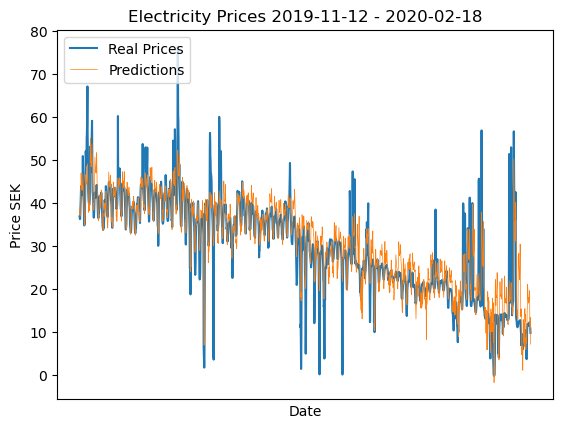

0
2020-02-18 - MAPE: 0.25%  |  MAE: 3.644  |  RMSE: 5.780
2020-02-19 - MAPE: 0.34%  |  MAE: 6.227  |  RMSE: 8.610
2020-02-20 - MAPE: 0.39%  |  MAE: 9.298  |  RMSE: 12.184
2020-02-21 - MAPE: 0.41%  |  MAE: 8.446  |  RMSE: 11.115
2020-02-22 - MAPE: 0.46%  |  MAE: 7.404  |  RMSE: 10.112
2020-02-23 - MAPE: 0.51%  |  MAE: 6.595  |  RMSE: 9.320
2020-02-24 - MAPE: 0.53%  |  MAE: 7.498  |  RMSE: 10.521
2020-02-25 - MAPE: 0.50%  |  MAE: 7.476  |  RMSE: 10.297
2020-02-26 - MAPE: 0.49%  |  MAE: 7.558  |  RMSE: 10.193
2020-02-27 - MAPE: 0.48%  |  MAE: 8.043  |  RMSE: 10.783
2020-02-28 - MAPE: 0.45%  |  MAE: 7.822  |  RMSE: 10.484
2020-02-29 - MAPE: 0.45%  |  MAE: 8.246  |  RMSE: 10.749
2020-03-01 - MAPE: 0.44%  |  MAE: 7.861  |  RMSE: 10.376
2020-03-02 - MAPE: 0.43%  |  MAE: 7.800  |  RMSE: 10.318
2020-03-03 - MAPE: 0.41%  |  MAE: 7.789  |  RMSE: 10.314
2020-03-04 - MAPE: 0.41%  |  MAE: 7.831  |  RMSE: 10.333
2020-03-05 - MAPE: 0.39%  |  MAE: 7.581  |  RMSE: 10.084
2020-03-06 - MAPE: 0.38%  |  MAE

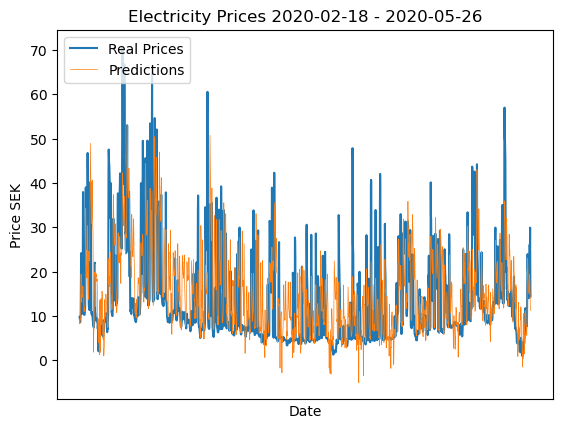

1
2020-05-26 - MAPE: 0.34%  |  MAE: 7.416  |  RMSE: 9.152
2020-05-27 - MAPE: 0.35%  |  MAE: 6.273  |  RMSE: 7.941
2020-05-28 - MAPE: 0.38%  |  MAE: 5.766  |  RMSE: 7.126
2020-05-29 - MAPE: 0.36%  |  MAE: 5.319  |  RMSE: 6.635
2020-05-30 - MAPE: 0.44%  |  MAE: 5.629  |  RMSE: 6.950
2020-05-31 - MAPE: 0.50%  |  MAE: 5.258  |  RMSE: 6.580
2020-06-01 - MAPE: 0.53%  |  MAE: 5.353  |  RMSE: 6.640
2020-06-02 - MAPE: 0.57%  |  MAE: 6.326  |  RMSE: 8.562
2020-06-03 - MAPE: 0.53%  |  MAE: 6.426  |  RMSE: 8.686
2020-06-04 - MAPE: 0.50%  |  MAE: 6.417  |  RMSE: 8.529
2020-06-05 - MAPE: 0.47%  |  MAE: 6.107  |  RMSE: 8.199
2020-06-06 - MAPE: 0.50%  |  MAE: 7.050  |  RMSE: 9.368
2020-06-07 - MAPE: 0.51%  |  MAE: 6.882  |  RMSE: 9.186
2020-06-08 - MAPE: 0.51%  |  MAE: 7.011  |  RMSE: 9.223
2020-06-09 - MAPE: 0.50%  |  MAE: 7.193  |  RMSE: 9.320
2020-06-10 - MAPE: 0.49%  |  MAE: 7.232  |  RMSE: 9.357
2020-06-11 - MAPE: 0.70%  |  MAE: 7.529  |  RMSE: 9.699
2020-06-12 - MAPE: 0.71%  |  MAE: 7.502  |  RM

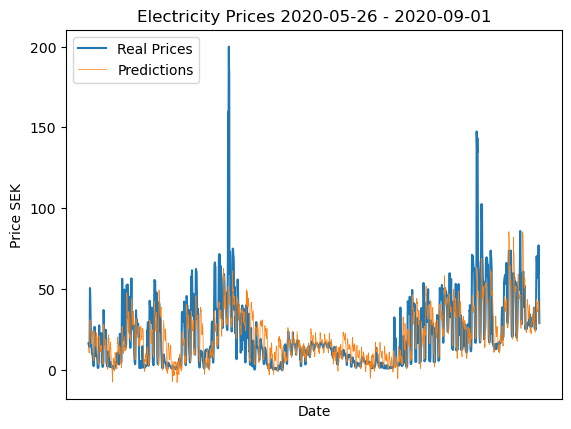

2
2020-09-01 - MAPE: 0.15%  |  MAE: 6.169  |  RMSE: 7.324
2020-09-02 - MAPE: 0.11%  |  MAE: 5.198  |  RMSE: 6.552
2020-09-03 - MAPE: 0.10%  |  MAE: 4.647  |  RMSE: 5.851
2020-09-04 - MAPE: 0.10%  |  MAE: 4.579  |  RMSE: 5.797
2020-09-05 - MAPE: 0.10%  |  MAE: 4.314  |  RMSE: 5.456
2020-09-06 - MAPE: 0.09%  |  MAE: 3.795  |  RMSE: 5.020
2020-09-07 - MAPE: 0.10%  |  MAE: 4.143  |  RMSE: 5.610
2020-09-08 - MAPE: 0.11%  |  MAE: 4.209  |  RMSE: 5.576
2020-09-09 - MAPE: 0.12%  |  MAE: 4.199  |  RMSE: 5.492
2020-09-10 - MAPE: 0.15%  |  MAE: 5.221  |  RMSE: 7.560
2020-09-11 - MAPE: 0.15%  |  MAE: 5.358  |  RMSE: 7.556
2020-09-12 - MAPE: 0.15%  |  MAE: 5.136  |  RMSE: 7.299
2020-09-13 - MAPE: 0.15%  |  MAE: 5.221  |  RMSE: 7.302
2020-09-14 - MAPE: 0.18%  |  MAE: 5.903  |  RMSE: 8.531
2020-09-15 - MAPE: 0.21%  |  MAE: 7.293  |  RMSE: 13.293
2020-09-16 - MAPE: 0.21%  |  MAE: 7.632  |  RMSE: 13.371
2020-09-17 - MAPE: 0.21%  |  MAE: 7.707  |  RMSE: 13.277
2020-09-18 - MAPE: 0.21%  |  MAE: 7.882  | 

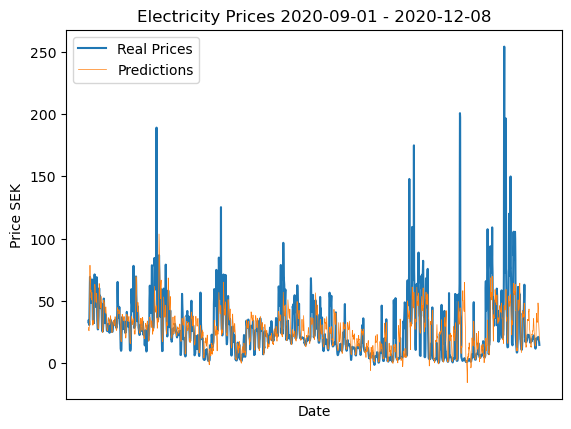

3
2020-12-08 - MAPE: 0.65%  |  MAE: 19.864  |  RMSE: 26.452
2020-12-09 - MAPE: 0.51%  |  MAE: 18.352  |  RMSE: 24.455
2020-12-10 - MAPE: 0.54%  |  MAE: 20.787  |  RMSE: 26.874
2020-12-11 - MAPE: 0.45%  |  MAE: 17.738  |  RMSE: 23.946
2020-12-12 - MAPE: 0.47%  |  MAE: 16.953  |  RMSE: 22.708
2020-12-13 - MAPE: 0.42%  |  MAE: 15.478  |  RMSE: 21.238
2020-12-14 - MAPE: 0.46%  |  MAE: 18.133  |  RMSE: 26.118
2020-12-15 - MAPE: 0.42%  |  MAE: 16.514  |  RMSE: 24.567
2020-12-16 - MAPE: 0.40%  |  MAE: 15.776  |  RMSE: 23.574
2020-12-17 - MAPE: 0.38%  |  MAE: 15.073  |  RMSE: 22.632
2020-12-18 - MAPE: 0.37%  |  MAE: 14.525  |  RMSE: 21.866
2020-12-19 - MAPE: 0.35%  |  MAE: 13.806  |  RMSE: 21.042
2020-12-20 - MAPE: 0.35%  |  MAE: 13.209  |  RMSE: 20.325
2020-12-21 - MAPE: 0.34%  |  MAE: 12.907  |  RMSE: 19.793
2020-12-22 - MAPE: 0.34%  |  MAE: 12.547  |  RMSE: 19.236
2020-12-23 - MAPE: 0.33%  |  MAE: 12.069  |  RMSE: 18.684
2020-12-24 - MAPE: 0.33%  |  MAE: 11.822  |  RMSE: 18.248
2020-12-25 -

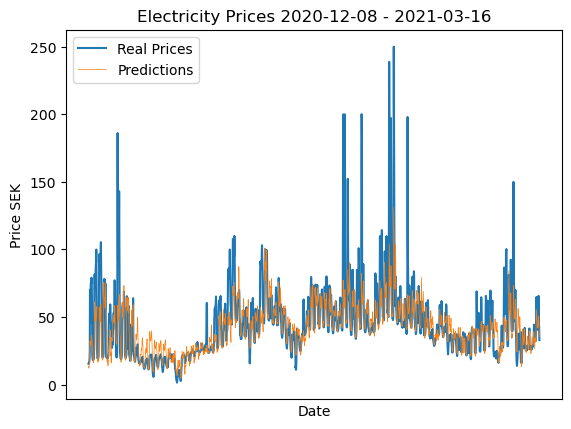

4
2021-03-16 - MAPE: 0.07%  |  MAE: 3.502  |  RMSE: 4.729
2021-03-17 - MAPE: 0.09%  |  MAE: 4.299  |  RMSE: 6.203
2021-03-18 - MAPE: 0.11%  |  MAE: 5.310  |  RMSE: 8.036
2021-03-19 - MAPE: 0.14%  |  MAE: 6.413  |  RMSE: 9.681
2021-03-20 - MAPE: 0.19%  |  MAE: 8.478  |  RMSE: 11.867
2021-03-21 - MAPE: 0.19%  |  MAE: 7.721  |  RMSE: 11.033
2021-03-22 - MAPE: 0.20%  |  MAE: 8.006  |  RMSE: 11.290
2021-03-23 - MAPE: 0.20%  |  MAE: 7.731  |  RMSE: 10.916
2021-03-24 - MAPE: 0.19%  |  MAE: 7.284  |  RMSE: 10.391
2021-03-25 - MAPE: 0.18%  |  MAE: 6.932  |  RMSE: 9.965
2021-03-26 - MAPE: 0.18%  |  MAE: 6.683  |  RMSE: 9.743
2021-03-27 - MAPE: 0.18%  |  MAE: 6.722  |  RMSE: 9.679
2021-03-28 - MAPE: 0.18%  |  MAE: 6.414  |  RMSE: 9.344
2021-03-29 - MAPE: 0.18%  |  MAE: 6.295  |  RMSE: 9.134
2021-03-30 - MAPE: 0.19%  |  MAE: 6.328  |  RMSE: 9.095
2021-03-31 - MAPE: 0.19%  |  MAE: 6.259  |  RMSE: 8.973
2021-04-01 - MAPE: 0.18%  |  MAE: 6.004  |  RMSE: 8.733
2021-04-02 - MAPE: 0.19%  |  MAE: 6.301  

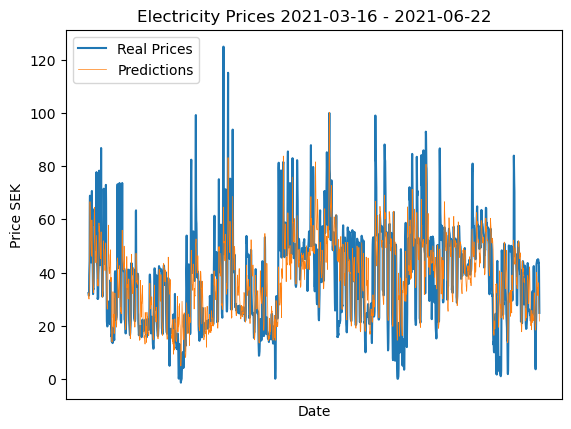

5
2021-06-22 - MAPE: 0.12%  |  MAE: 3.613  |  RMSE: 4.463
2021-06-23 - MAPE: 0.10%  |  MAE: 3.168  |  RMSE: 3.983
2021-06-24 - MAPE: 0.11%  |  MAE: 3.388  |  RMSE: 4.306
2021-06-25 - MAPE: 0.11%  |  MAE: 3.575  |  RMSE: 4.343
2021-06-26 - MAPE: 0.11%  |  MAE: 3.531  |  RMSE: 4.250
2021-06-27 - MAPE: 0.10%  |  MAE: 3.175  |  RMSE: 3.942
2021-06-28 - MAPE: 0.12%  |  MAE: 4.009  |  RMSE: 5.381
2021-06-29 - MAPE: 0.11%  |  MAE: 3.932  |  RMSE: 5.223
2021-06-30 - MAPE: 0.11%  |  MAE: 3.773  |  RMSE: 5.028
2021-07-01 - MAPE: 0.10%  |  MAE: 3.692  |  RMSE: 4.907
2021-07-02 - MAPE: 0.11%  |  MAE: 4.008  |  RMSE: 5.224
2021-07-03 - MAPE: 0.11%  |  MAE: 4.099  |  RMSE: 5.256
2021-07-04 - MAPE: 0.12%  |  MAE: 4.452  |  RMSE: 5.745
2021-07-05 - MAPE: 0.12%  |  MAE: 4.703  |  RMSE: 6.625
2021-07-06 - MAPE: 0.12%  |  MAE: 4.993  |  RMSE: 7.444
2021-07-07 - MAPE: 0.13%  |  MAE: 5.749  |  RMSE: 9.231
2021-07-08 - MAPE: 0.13%  |  MAE: 6.166  |  RMSE: 9.761
2021-07-09 - MAPE: 0.14%  |  MAE: 6.445  |  RM

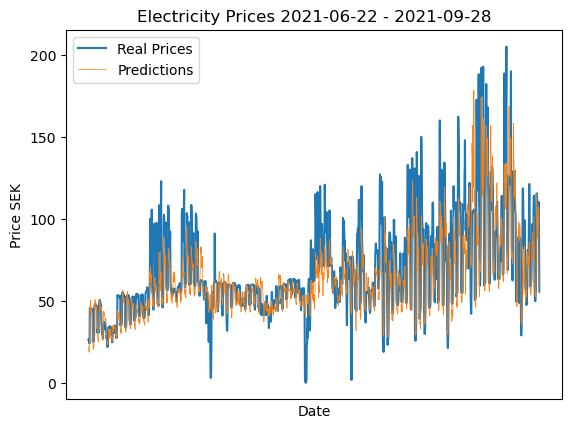

6
2021-09-28 - MAPE: 0.21%  |  MAE: 17.167  |  RMSE: 19.898
2021-09-29 - MAPE: 0.17%  |  MAE: 14.222  |  RMSE: 16.998
2021-09-30 - MAPE: 0.17%  |  MAE: 13.894  |  RMSE: 16.943
2021-10-01 - MAPE: 0.20%  |  MAE: 15.194  |  RMSE: 18.091
2021-10-02 - MAPE: 0.24%  |  MAE: 16.323  |  RMSE: 20.200
2021-10-03 - MAPE: 0.34%  |  MAE: 20.583  |  RMSE: 26.219
2021-10-04 - MAPE: 0.43%  |  MAE: 22.084  |  RMSE: 28.580
2021-10-05 - MAPE: 0.42%  |  MAE: 21.797  |  RMSE: 28.106
2021-10-06 - MAPE: 0.41%  |  MAE: 21.691  |  RMSE: 27.856
2021-10-07 - MAPE: 0.40%  |  MAE: 22.055  |  RMSE: 28.110
2021-10-08 - MAPE: 0.38%  |  MAE: 21.487  |  RMSE: 27.455
2021-10-09 - MAPE: 0.36%  |  MAE: 20.730  |  RMSE: 26.717
2021-10-10 - MAPE: 0.36%  |  MAE: 20.710  |  RMSE: 26.342
2021-10-11 - MAPE: 0.39%  |  MAE: 21.999  |  RMSE: 28.130
2021-10-12 - MAPE: 0.39%  |  MAE: 22.394  |  RMSE: 28.977
2021-10-13 - MAPE: 0.39%  |  MAE: 24.219  |  RMSE: 31.623
2021-10-14 - MAPE: 0.39%  |  MAE: 25.995  |  RMSE: 33.982
2021-10-15 -

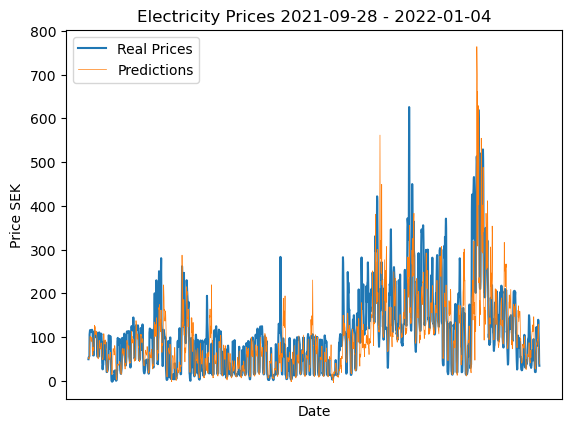

7
2022-01-04 - MAPE: 0.65%  |  MAE: 46.279  |  RMSE: 51.713
2022-01-05 - MAPE: 0.42%  |  MAE: 35.749  |  RMSE: 42.763
2022-01-06 - MAPE: 0.48%  |  MAE: 45.652  |  RMSE: 57.998
2022-01-07 - MAPE: 0.40%  |  MAE: 40.086  |  RMSE: 52.369
2022-01-08 - MAPE: 0.36%  |  MAE: 36.504  |  RMSE: 48.254
2022-01-09 - MAPE: 0.36%  |  MAE: 36.551  |  RMSE: 47.830
2022-01-10 - MAPE: 0.37%  |  MAE: 40.851  |  RMSE: 53.208
2022-01-11 - MAPE: 0.35%  |  MAE: 42.506  |  RMSE: 54.759
2022-01-12 - MAPE: 0.35%  |  MAE: 42.372  |  RMSE: 54.733
2022-01-13 - MAPE: 0.37%  |  MAE: 41.463  |  RMSE: 53.340
2022-01-14 - MAPE: 0.41%  |  MAE: 40.257  |  RMSE: 52.257
2022-01-15 - MAPE: 0.45%  |  MAE: 42.342  |  RMSE: 54.989
2022-01-16 - MAPE: 0.47%  |  MAE: 45.009  |  RMSE: 58.561
2022-01-17 - MAPE: 0.52%  |  MAE: 45.131  |  RMSE: 58.564
2022-01-18 - MAPE: 0.52%  |  MAE: 44.982  |  RMSE: 58.394
2022-01-19 - MAPE: 0.52%  |  MAE: 45.907  |  RMSE: 59.110
2022-01-20 - MAPE: 0.56%  |  MAE: 45.550  |  RMSE: 58.564
2022-01-21 -

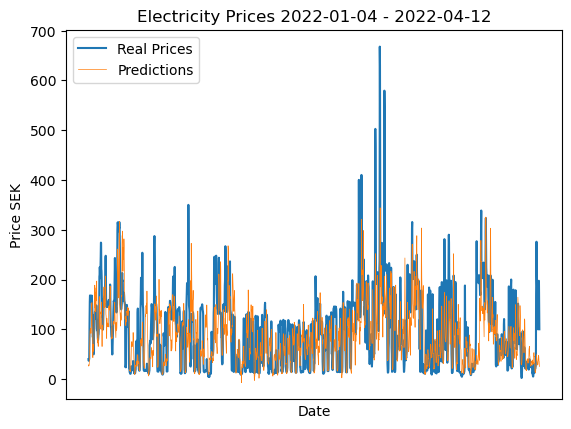

8
2022-04-12 - MAPE: 0.56%  |  MAE: 52.143  |  RMSE: 61.135
2022-04-13 - MAPE: 0.36%  |  MAE: 34.638  |  RMSE: 45.548
2022-04-14 - MAPE: 0.36%  |  MAE: 33.200  |  RMSE: 43.264
2022-04-15 - MAPE: 0.33%  |  MAE: 31.436  |  RMSE: 41.629
2022-04-16 - MAPE: 0.30%  |  MAE: 26.935  |  RMSE: 37.539
2022-04-17 - MAPE: 0.29%  |  MAE: 24.462  |  RMSE: 34.810
2022-04-18 - MAPE: 0.28%  |  MAE: 23.485  |  RMSE: 33.503
2022-04-19 - MAPE: 0.29%  |  MAE: 24.609  |  RMSE: 36.823
2022-04-20 - MAPE: 0.27%  |  MAE: 23.052  |  RMSE: 34.976
2022-04-21 - MAPE: 0.28%  |  MAE: 23.597  |  RMSE: 34.503
2022-04-22 - MAPE: 0.28%  |  MAE: 22.691  |  RMSE: 33.260
2022-04-23 - MAPE: 0.28%  |  MAE: 21.566  |  RMSE: 32.011
2022-04-24 - MAPE: 0.34%  |  MAE: 22.885  |  RMSE: 34.068
2022-04-25 - MAPE: 0.37%  |  MAE: 26.702  |  RMSE: 39.781
2022-04-26 - MAPE: 0.39%  |  MAE: 28.505  |  RMSE: 41.681
2022-04-27 - MAPE: 0.39%  |  MAE: 29.685  |  RMSE: 42.726
2022-04-28 - MAPE: 0.39%  |  MAE: 30.242  |  RMSE: 43.097
2022-04-29 -

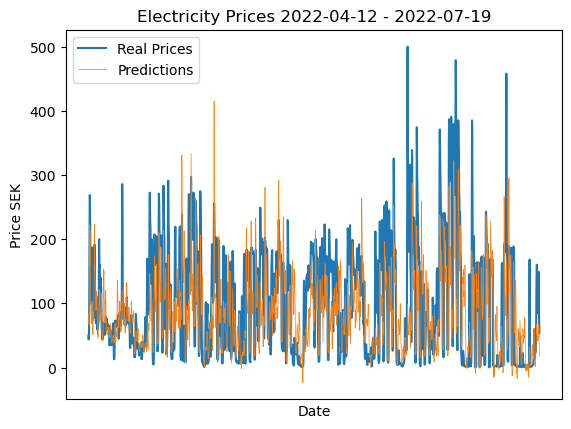

In [61]:
dfTrain = dataframe[~(dataframe.index >= "2019-11-12")]
dfTest = dataframe[~(dataframe.index < "2019-11-12")]
noOfTestDays = len(dfTest) / 24
noOfBatches = 10
batchSize = noOfTestDays // noOfBatches

testStartDate = dfTest.index[0]
for batch in range(noOfBatches):
    testEndDate = testStartDate + pd.Timedelta(days=batchSize)
    testBatch = dfTest[(dfTest.index >= str(testStartDate).split()[0]) & (dfTest.index < str(testEndDate).split()[0])]

    mae, mape, rmse = evaluate_lear_in_test_dataset(path_recalibration_folder=path_recalibration_folder, dataset=setName, df_test=testBatch, df_train=dfTrain, batch=batch)
    resultMAE = np.mean(mae)
    resultRMSE = np.mean(rmse)
    resultMAPE = np.mean(mape)
    
    pathToFile = "./experimental_files/LEAR_val_" + str(batch + 1) + ".csv"
    result = pd.read_csv(pathToFile)
    realMap = pd.DataFrame(index=testBatch.index[::24], columns=['h' + str(k) for k in range(24)])
    real_prices = testBatch.loc[:, ['Price']].values.reshape(-1, 24)
    real_prices = pd.DataFrame(real_prices, index=realMap.index, columns=realMap.columns)

    result.index = result["Date"]
    result.index = pd.to_datetime(result.index)
    result = result.drop(["Date"], axis=1)

    resultValues = result.values.ravel()
    realValues = real_prices.values.ravel()
    plotValues = {"Predictions": resultValues, "Prices": realValues}
    plotDf = pd.DataFrame(index=testBatch.index, data=plotValues)


    plt.plot(plotDf.index, plotDf["Prices"], label="Real Prices")
    plt.plot(plotDf.index, plotDf["Predictions"], linewidth=0.5, label="Predictions")

    plt.legend(loc="upper left")

    plt.xlabel("Date")
    plt.ylabel("Price SEK")
    plt.xticks([])


    plt.title("Electricity Prices " + str(testStartDate).split()[0] + " - " + str(testEndDate).split()[0])
    print("MAE: " + str(resultMAE))
    print("RMSE: " + str(resultRMSE))
    plt.show()
    
    if batch != 9:
        print(batch)
        dfTrain = pd.concat([dfTrain, testBatch])
        testStartDate += pd.Timedelta(days=batchSize)

#mae, mape, rmse = evaluate_lear_in_test_dataset(path_recalibration_folder=path_recalibration_folder, dataset=setName, df_test=dfTest, df_train=dfTrain)

# SCORES AND PLOTS

In [64]:
result = pd.read_csv("./experimental_files/LEAR_forecast_datSE3_YT2_CW1092.csv")

realMap = pd.DataFrame(index=dfTest.index[::24], columns=['h' + str(k) for k in range(24)])
real_prices = dfTest.loc[:, ['Price']].values.reshape(-1, 24)
real_prices = pd.DataFrame(real_prices, index=realMap.index, columns=realMap.columns)

result.index = result["Date"]
result.index = pd.to_datetime(result.index)
result = result.drop(["Date"], axis=1)


In [65]:
resultMAE = np.mean(mae)
resultRMSE = np.mean(rmse)
resultMAPE = np.mean(mape)

MAE: 21.001554413817235
RMSE: 32.987959239996776


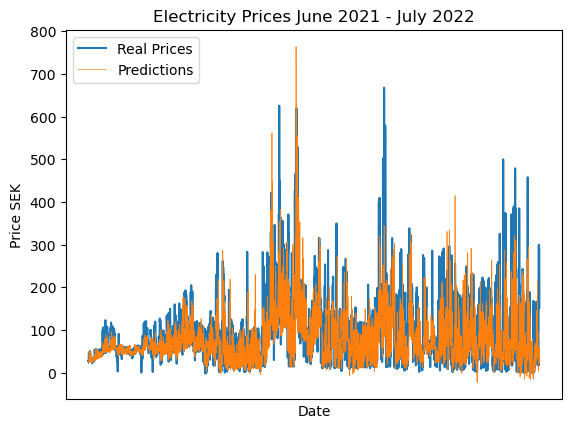

In [67]:
resultValues = result.values.ravel()
realValues = real_prices.values.ravel()
plotValues = {"Predictions": resultValues, "Prices": realValues}
plotDf = pd.DataFrame(index=dfTest.index, data=plotValues)


plt.plot(plotDf.index, plotDf["Prices"], label="Real Prices")
plt.plot(plotDf.index, plotDf["Predictions"], linewidth=0.5, label="Predictions")

plt.legend(loc="upper left")

plt.xlabel("Date")
plt.ylabel("Price SEK")
plt.xticks([])


plt.title("Electricity Prices June 2021 - July 2022")
print("MAE: " + str(resultMAE))
print("RMSE: " + str(resultRMSE))
plt.show()

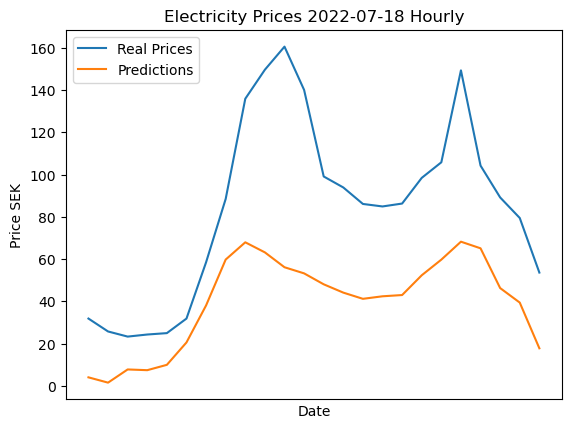

In [7]:
hourlyPredictionsDf = pd.read_csv("./experimental_files/DayCast.csv")

plt.plot(hourlyPredictionsDf["Date"], hourlyPredictionsDf["Price"], label="Real Prices")
plt.plot(hourlyPredictionsDf["Date"], hourlyPredictionsDf["Prediction"], label ="Predictions")
plt.xlabel("Date")
plt.ylabel("Price SEK")
plt.xticks([])
plt.legend(loc="upper left")

plt.title("Electricity Prices 2022-07-18 Hourly")
plt.show()